In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import KernelPCA

In [17]:
# data=pd.read_csv('cluster1.csv')
data = pd.read_csv("c:/Users/USER/OneDrive - TNDigi Digital Marketing/Attachments/Uyen/Project/Ellie/PROJECT/3. Delta/Data/combine19.csv")

data['Index'] = range(len(data))
fig, ax = plt.subplots(figsize=(15, 3))  
ax.plot(data['Index'], data['Load'], color='blue', label='Load')
plt.xlabel('Time (15-min interval)', fontsize=12)
plt.ylabel('Load (kW)', fontsize=12)
plt.xlim([0, len(data)]) 
plt.ylim([data['Load'].min() - 5, data['Load'].max() + 5])  
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/USER/OneDrive - TNDigi Digital Marketing/Attachments/Uyen/Project/Ellie/PROJECT/3. Delta/Data/combine19.csv'

In [35]:
import pandas as pd

data = pd.read_csv("c:/Users/USER/OneDrive - TNDigi Digital Marketing/Attachments/Uyen/Project/Ellie/PROJECT/3. Delta/Data/combine19.csv")
total_samples = len(data)
train_percentage = 0.9
train_size = int(total_samples * train_percentage)
train_size = train_size - (train_size % 96)
test_size = total_samples - train_size
test_size = test_size - (test_size % 96)
train_size = total_samples - test_size
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:train_size + test_size]

train_data.to_csv("train_delta.csv", index=False)
test_data.to_csv("test_delta.csv", index=False)

print(f"Total samples: {total_samples}")
print(f"Training data length: {len(train_data)} (Divisible by 96: {len(train_data) % 96 == 0})")
print(f"Testing data length: {len(test_data)} (Divisible by 96: {len(test_data) % 96 == 0})")
print("Training and testing data have been saved to 'train_data.csv' and 'test_data.csv', respectively.")


Total samples: 9792
Training data length: 8736 (Divisible by 96: True)
Testing data length: 1056 (Divisible by 96: True)
Training and testing data have been saved to 'train_data.csv' and 'test_data.csv', respectively.


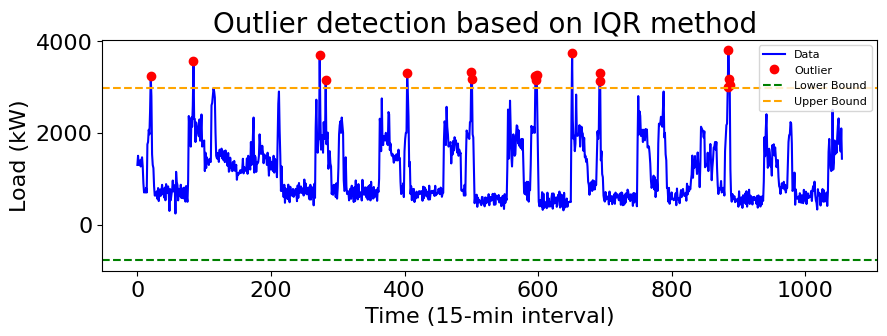

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('test_delta.csv')
col = 'Load'
Q1 = data[col].quantile(0.25)
Q3 = data[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_mask = (data[col] < lower_bound) | (data[col] > upper_bound)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(data.index, data[col], label='Data', color='blue')
ax.plot(data.index[outliers_mask], data[col][outliers_mask], 'ro', label='Outlier')
ax.axhline(y=lower_bound, color='green', linestyle='--', label='Lower Bound')
ax.axhline(y=upper_bound, color='orange', linestyle='--', label='Upper Bound')
ax.set_title(f'Outlier detection based on IQR method ', fontsize=20)
ax.set_xlabel('Time (15-min interval)', fontsize=16)
ax.set_ylabel('Load (kW)', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(fontsize=8)
plt.show()


In [75]:

num_outliers = sum(outliers_mask)
percentage_outliers = (num_outliers / len(data)) * 100

print(f"number of outliers: {num_outliers}")
print(f"percent of outliers: {percentage_outliers:.2f}%")

number of outliers: 17
percent of outliers: 1.61%


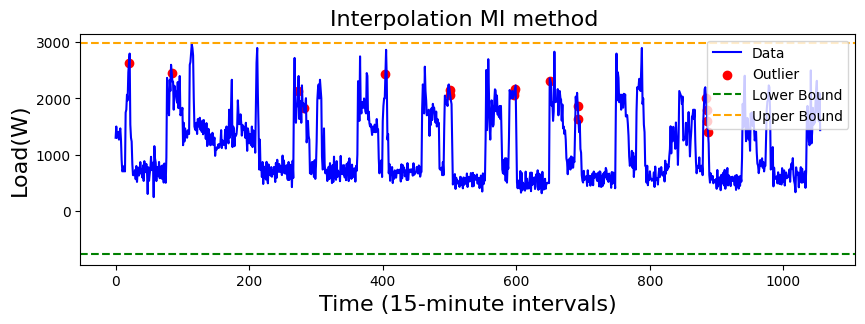

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



data.loc[outliers_mask, col] = np.nan
data[col] = data[col].interpolate(method='linear')
data.loc[outliers_mask, col] = data.loc[outliers_mask, col]


plt.figure(figsize=(10, 3))
plt.plot(data.index, data[col], label='Data', color='blue')
plt.scatter(data.index[outliers_mask], data.loc[outliers_mask, col], label='Outlier', color='red')
plt.axhline(y=lower_bound, color='green', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='orange', linestyle='--', label='Upper Bound')
plt.title('Interpolation MI method ',fontsize=16)
plt.xlabel('Time (15-minute intervals)',fontsize=16)
plt.ylabel(col)
plt.ylabel('Load(W)', fontsize=16) 


plt.xticks(fontsize=10) 
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.legend(loc='upper right')

plt.show()


In [2]:
data.to_csv('test_delta_o.csv')

NameError: name 'data' is not defined

In [18]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep, window_size, target_step):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step
        self.models = {}
        self.results = {}
    def create_rolling_features(self, data, roll_window=4):
        data = data.copy()
        data['Load_roll_mean'] = data['Load'].rolling(window=roll_window).mean()
        data['Load_roll_std'] = data['Load'].rolling(window=roll_window).std()
        data.fillna(method='bfill', inplace=True)
        return data
    def create_sliding_window(self, data):
        X, y = [], []
        for i in range(len(data) - self.window_size - self.target_step):
            X.append(data.iloc[i:i+self.window_size, 1:].values.flatten())  
            y.append(data['Load'].iloc[i+self.window_size+self.target_step])  
        return np.array(X), np.array(y)
    def preprocess_data(self):
        self.train_data = self.create_rolling_features(self.train_data)
        self.test_data = self.create_rolling_features(self.test_data)
        X_train, y_train = self.create_sliding_window(self.train_data)
        X_test, y_test = self.create_sliding_window(self.test_data)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_model(self, model_name, model, param_dist, random_state, X_train, y_train):
        best_estimator = None
        best_score = float("inf")
        tscv = TimeSeriesSplit(n_splits=5)

        while True:
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                n_iter=10,
                scoring='neg_mean_squared_error',
                cv=tscv,
                verbose=1,
                random_state=random_state,
                n_jobs=-1
            )
            random_search.fit(X_train, y_train)

            if -random_search.best_score_ < best_score:
                best_score = -random_search.best_score_
                best_estimator = random_search.best_estimator_
            else:
                break

        self.models[model_name] = best_estimator
        return best_estimator

    def predict(self, model_name, X_test, y_test):
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' is not trained yet.")
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        self.results[model_name] = {
            "y_pred": y_pred,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained Variance": evs,
                "MAPE": mape
            }
        }
        return self.results[model_name]

    def plot_results(self, model_name, y_test):
        y_pred = self.results[model_name]["y_pred"]
        plt.figure(figsize=(10, 3))
        plt.plot(y_test, label='Actual', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.legend()
        plt.xlabel("Time (15-min interval)")
        plt.ylabel("Load (kW)")
        plt.title(f"Actual vs Predicted Load - {model_name}")
        plt.grid()
        plt.show()

if __name__ == "__main__":
    train_data = pd.read_csv("train_delta_c.csv")
    test_data = pd.read_csv("test_delta_o.csv")

    features_to_keep = [
        'Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
        'relative_humidity','clearsky_dni','zenith',
        'Day','Month','D_1_h','D_2_h','D_3_h',
        'uv_index','dewpoint_temp','Hour','Minute'
    ]
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    manager = ModelManager(
        train_data=train_data,
        test_data=test_data,
        features_to_keep=features_to_keep,
        window_size=4,   
        target_step=0    
    )

    X_train, X_test, y_train, y_test = manager.preprocess_data()



## Decision Tree

In [20]:

param_dist_decision_tree = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dt_model = DecisionTreeRegressor(random_state=42)

manager.train_model(
    model_name="Decision Tree Regressor",
    model=dt_model,
    param_dist=param_dist_decision_tree,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)

dt_results = manager.predict("Decision Tree Regressor", X_test, y_test)
print("\nDecision Tree Regressor Results:")
for metric_name, metric_value in dt_results["metrics"].items():
    print(f"{metric_name}: {metric_value:.4f}")

# manager.plot_results("Decision Tree Regressor", y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Decision Tree Regressor Results:
MSE: 172145.6456
RMSE: 414.9044
MAE: 289.2710
R2: 0.5355
Explained Variance: 0.5591
MAPE: 26.8541


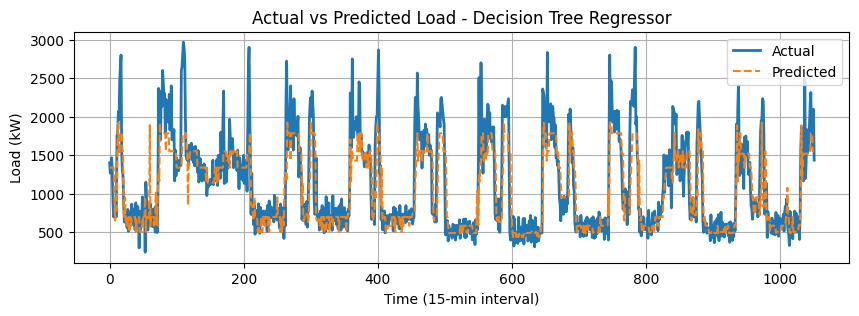

In [80]:
manager.plot_results("Decision Tree Regressor", y_test)

## Random Forest

In [81]:
from sklearn.ensemble import RandomForestRegressor

param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)

manager.train_model(
    model_name="Random Forest Regressor",
    model=rf_model,
    param_dist=param_dist_rf,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)

rf_results = manager.predict("Random Forest Regressor", X_test, y_test)
print("\nRandom Forest Regressor Results:")
for k, v in rf_results["metrics"].items():
    print(f"{k}: {v:.4f}")

# manager.plot_results("Random Forest Regressor", y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Random Forest Regressor Results:
MSE: 95797.8553
RMSE: 309.5123
MAE: 208.3157
R2: 0.7415
Explained Variance: 0.7544
MAPE: 19.8349


## XGBoost

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

XGBoost Regressor Results:
MSE: 94275.4952
RMSE: 307.0431
MAE: 208.2769
R2: 0.7456
Explained Variance: 0.7518
MAPE: 20.0677


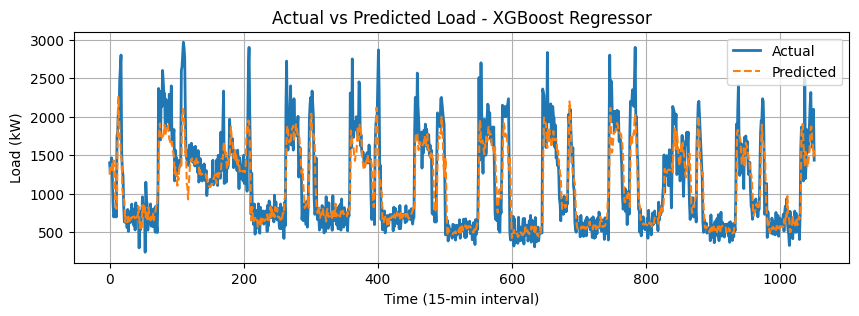

In [82]:
from xgboost import XGBRegressor

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}
xgb_model = XGBRegressor(random_state=42, verbosity=0)
manager.train_model(
    model_name="XGBoost Regressor",
    model=xgb_model,
    param_dist=param_dist_xgb,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)
xgb_results = manager.predict("XGBoost Regressor", X_test, y_test)
print("\nXGBoost Regressor Results:")
for k, v in xgb_results["metrics"].items():
    print(f"{k}: {v:.4f}")
manager.plot_results("XGBoost Regressor", y_test)



## CatBoost

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits

CatBoost Regressor Results:
MSE: 88389.8583
RMSE: 297.3043
MAE: 200.3668
R2: 0.7615
Explained Variance: 0.7656
MAPE: 19.3898


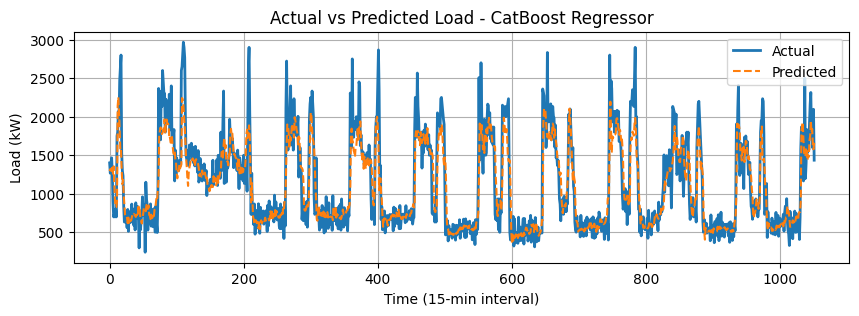

In [83]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    silent=True,
    random_state=42,   
)
param_dist_cat = {
    'iterations': [300, 500, 800, 1000],
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 10],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'bagging_temperature': [0, 0.5, 1, 2],
    'random_strength': [1, 2, 5, 10],

}
manager.train_model(
    model_name="CatBoost Regressor",
    model=cat_model,
    param_dist=param_dist_cat,
    random_state=42,
    X_train=X_train,
    y_train=y_train
)
cat_results = manager.predict("CatBoost Regressor", X_test, y_test)
print("\nCatBoost Regressor Results:")
for k, v in cat_results["metrics"].items():
    print(f"{k}: {v:.4f}")

manager.plot_results("CatBoost Regressor", y_test)

## RNN

Epoch 1/100
96/96 [==============================] - 2s 6ms/step - loss: 627217.5000 - mae: 694.4230 - val_loss: 286662.8125 - val_mae: 467.4913
Epoch 2/100
96/96 [==============================] - 0s 3ms/step - loss: 113292.3672 - mae: 251.2241 - val_loss: 71186.9375 - val_mae: 176.6910
Epoch 3/100
96/96 [==============================] - 0s 3ms/step - loss: 83417.2344 - mae: 212.9333 - val_loss: 64639.6055 - val_mae: 193.7664
Epoch 4/100
96/96 [==============================] - 0s 3ms/step - loss: 74988.8984 - mae: 202.8794 - val_loss: 69085.4141 - val_mae: 207.9904
Epoch 5/100
96/96 [==============================] - 0s 3ms/step - loss: 73677.5312 - mae: 197.8885 - val_loss: 63022.5625 - val_mae: 195.6014
Epoch 6/100
96/96 [==============================] - 0s 4ms/step - loss: 69928.7422 - mae: 191.4152 - val_loss: 63783.5273 - val_mae: 196.4991
Epoch 7/100
96/96 [==============================] - 0s 3ms/step - loss: 65239.4219 - mae: 185.0291 - val_loss: 65974.2969 - val_mae: 202.6

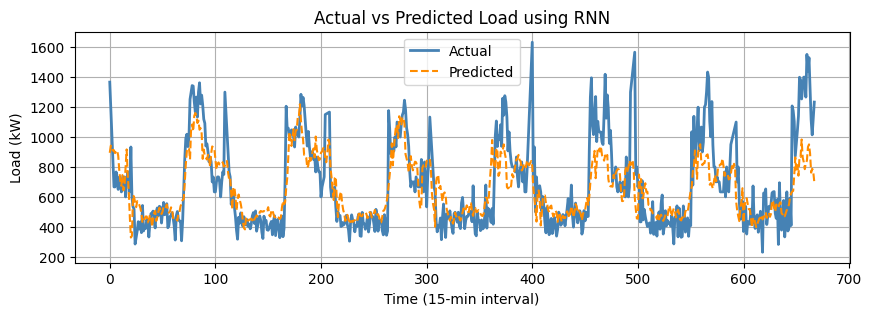

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

train_data = pd.read_csv("train_delta_o.csv")
test_data = pd.read_csv("test_delta_o.csv")

features_to_keep = ['Load', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'Pc_1',
                    'Pc_2', 'Pc_3', 'Pc_4', 'Pc_5', 'Pc_6', 'Pc_7',
                    'relative_humidity', 'clearsky_dni', 'zenith', 'Day', 'Month', 
                    'D_1_h', 'D_2_h', 'D_3_h', 'uv_index', 'dewpoint_temp', 'Hour', 'Minute']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

def create_sliding_window(data, window_size, target_step):
    X, y = [], []
    for i in range(len(data) - window_size - target_step):
        X.append(data.iloc[i:i+window_size, 1:].values)  
        y.append(data['Load'].iloc[i+window_size+target_step])  
    return np.array(X), np.array(y)

window_size = 4  
target_step = 0  

X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_test_flat = X_test.reshape(-1, X_test.shape[2])

X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

model = Sequential()

model.add(SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(SimpleRNN(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping], 
    verbose=1
)

y_pred_rnn = model.predict(X_test_scaled)

mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)
r2_rnn = r2_score(y_test, y_pred_rnn)
mape_rnn = np.mean(np.abs((y_test - y_pred_rnn.flatten()) / y_test)) * 100

print("RNN Model Metrics:")
print("MSE:", mse_rnn)
print("RMSE:", rmse_rnn)
print("MAE:", mae_rnn)
print("R2:", r2_rnn)
print("MAPE:", mape_rnn)

plt.figure(figsize=(10, 3))
plt.plot(y_test, label='Actual', linewidth=2, color='steelblue')
plt.plot(y_pred_rnn, label='Predicted', linestyle='--', color='darkorange')
plt.legend()
plt.xlabel("Time (15-min interval)")
plt.ylabel("Load (kW)")
plt.title("Actual vs Predicted Load using RNN")
plt.grid()
plt.show()


## LSTM

Epoch 1/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1010392.5625 - mae: 847.5095 - val_loss: 202119.6875 - val_mae: 346.0326
Epoch 2/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147819.2500 - mae: 273.1514 - val_loss: 91049.0547 - val_mae: 197.2175
Epoch 3/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121938.0312 - mae: 245.5799 - val_loss: 82988.4609 - val_mae: 189.9373
Epoch 4/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118480.9141 - mae: 237.4126 - val_loss: 86338.0859 - val_mae: 189.5177
Epoch 5/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111063.3750 - mae: 229.2758 - val_loss: 79515.0469 - val_mae: 196.0231
Epoch 6/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94907.7266 - mae: 212.3921 - val_loss: 85555.9688 - val_mae: 209.4987
Epoch 7/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92698.7969 - mae: 209.0704 - val_loss: 78975.8516 - val_mae: 201.9383
Epoch 8/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90857.0156 - ma

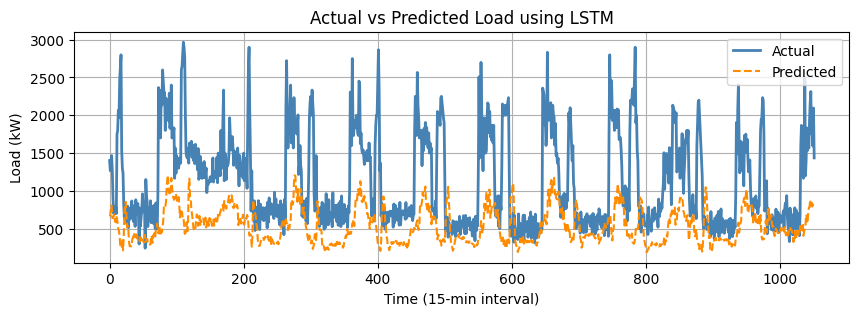

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

train_data = pd.read_csv("train_delta_c.csv")
test_data = pd.read_csv("test_delta_o.csv")

features_to_keep = ['Load', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'Pc_1',
                    'Pc_2', 'Pc_3', 'Pc_4', 'Pc_5', 'Pc_6', 'Pc_7',
                    'relative_humidity', 'clearsky_dni', 'zenith', 'Day', 'Month', 
                    'D_1_h', 'D_2_h', 'D_3_h', 'uv_index', 'dewpoint_temp', 'Hour', 'Minute']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

def create_sliding_window(data, window_size, target_step):
    X, y = [], []
    for i in range(len(data) - window_size - target_step):
        X.append(data.iloc[i:i+window_size, 1:].values)  
        y.append(data['Load'].iloc[i+window_size+target_step])  
    return np.array(X), np.array(y)

window_size = 4  
target_step = 0  

X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_test_flat = X_test.reshape(-1, X_test.shape[2])

X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

model = Sequential()

model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))  
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train, 
    epochs=150, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping], 
    verbose=1
)
y_pred_lstm = model.predict(X_test_scaled)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test - y_pred_lstm.flatten()) / y_test)) * 100

print("LSTM Model Metrics:")
print("MSE:", mse_lstm)
print("RMSE:", rmse_lstm)
print("MAE:", mae_lstm)
print("R2:", r2_lstm)
print("MAPE:", mape_lstm)


plt.figure(figsize=(10, 3))
plt.plot(y_test, label='Actual', linewidth=2, color='steelblue')
plt.plot(y_pred_lstm, label='Predicted', linestyle='--', color='darkorange')
plt.legend()
plt.xlabel("Time (15-min interval)")
plt.ylabel("Load (kW)")
plt.title("Actual vs Predicted Load using LSTM")
plt.grid()
plt.show()


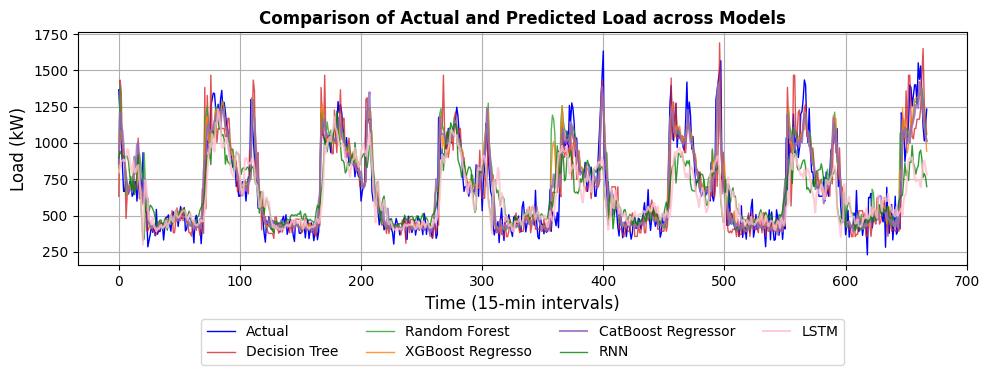

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual',linewidth=1, color='blue', alpha=1)

dt_predictions = manager.results["Decision Tree Regressor"]["y_pred"]
plt.plot(dt_predictions, label='Decision Tree', linestyle='-', linewidth=1, color='#d62728', alpha=0.8)
rf_predictions = manager.results["Random Forest Regressor"]["y_pred"]
plt.plot(rf_predictions, label='Random Forest',linestyle='-',  linewidth=1, color='#2ca02c', alpha=0.8)
xg_predictions=manager.results['XGBoost Regressor']['y_pred']
plt.plot(xg_predictions, label='XGBoost Regresso', linestyle='-', linewidth=1, color='#ff7f0e', alpha=0.8)
cb_predictions=manager.results['CatBoost Regressor']['y_pred']
plt.plot(cb_predictions, label='CatBoost Regressor',  linestyle='-', color='#9467bd', alpha=0.8)
plt.plot(y_pred_rnn, label='RNN', linestyle='-', linewidth=1, color='green', alpha=0.8)
plt.plot(y_pred_lstm, label='LSTM', linestyle='-', color='pink', alpha=0.8)
plt.title("Comparison of Actual and Predicted Load across Models",fontweight="bold")

plt.xlabel("Time (15-min intervals)", fontsize=12)
plt.ylabel("Load (kW)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), fontsize=10, ncol=4)
plt.grid()
plt.tight_layout()
plt.show()


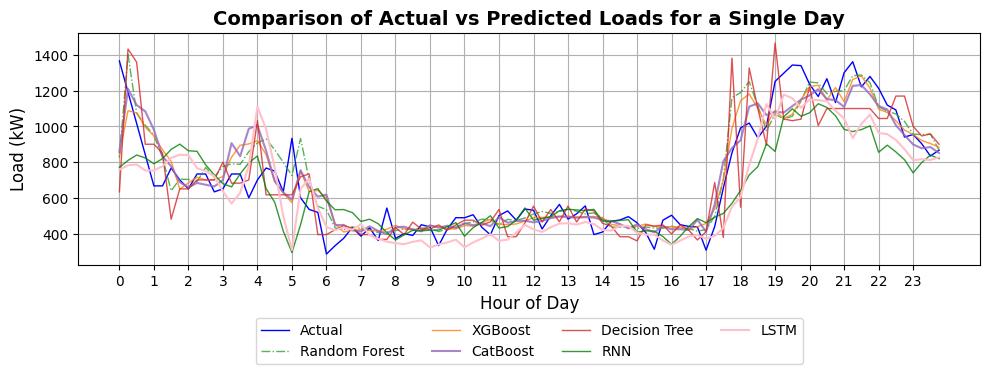

In [211]:
steps_per_day = 96
y_test_actual_day1 = y_test[:steps_per_day]
y_pred_rf_day1 = rf_predictions[:steps_per_day]
y_pred_xgb_day1 = xg_predictions[:steps_per_day]
y_pred_cb_day1 = cb_predictions[:steps_per_day]
y_pred_dt_day1 = dt_predictions[:steps_per_day]
y_pred_rnn_day1 = y_pred_rnn[:steps_per_day]
y_pred_lstm_day1 = y_pred_lstm[:steps_per_day]

hour_labels_day1 = test_data['Hour'][:steps_per_day].values  
xticks_positions = list(range(0, steps_per_day, 4))  
xticks_labels = hour_labels_day1[xticks_positions]  

plt.figure(figsize=(10, 4))  
plt.plot(y_test_actual_day1, label='Actual', linewidth=1, color='blue', alpha=1)  # Xanh dương cổ điển
plt.plot(y_pred_rf_day1, label='Random Forest', linestyle='-.', linewidth=1, color='#2ca02c', alpha=0.8)  # Xanh lá tự nhiên
plt.plot(y_pred_xgb_day1, label='XGBoost', linestyle='-', linewidth=1, color='#ff7f0e', alpha=0.8)  # Cam đất
plt.plot(y_pred_cb_day1, label='CatBoost', linestyle='-', color='#9467bd', alpha=0.8)  # Tím nhạt
plt.plot(y_pred_dt_day1, label='Decision Tree', linestyle='-', linewidth=1, color='#d62728', alpha=0.8)  # Đỏ rượu
plt.plot(y_pred_rnn_day1, label='RNN', linestyle='-', linewidth=1, color='green', alpha=0.8)  # Nâu trung tính
plt.plot(y_pred_lstm_day1, label='LSTM', linestyle='-', color='pink')

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), fontsize=10, ncol=4)
plt.xticks(ticks=xticks_positions, labels=xticks_labels, fontsize=10)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Load (kW)", fontsize=12)
plt.title("Comparison of Actual vs Predicted Loads for a Single Day", fontsize=14, fontweight="bold")
plt.grid()
plt.tight_layout()  
plt.show()


## Transformer

Epoch [1/1000] - Train Loss: 0.3782, Val Loss: 0.1889, LR=0.001
Test Loss: 0.7620
MAPE: 24.57%
Epoch [2/1000] - Train Loss: 0.2419, Val Loss: 0.1759, LR=0.001
Test Loss: 0.7071
MAPE: 28.33%
Epoch [3/1000] - Train Loss: 0.2250, Val Loss: 0.1771, LR=0.001
Test Loss: 0.6841
MAPE: 26.63%
Epoch [4/1000] - Train Loss: 0.2239, Val Loss: 0.1690, LR=0.001
Test Loss: 0.8344
MAPE: 26.11%
Epoch [5/1000] - Train Loss: 0.1962, Val Loss: 0.1604, LR=0.001
Test Loss: 0.6962
MAPE: 24.86%
Epoch [6/1000] - Train Loss: 0.1987, Val Loss: 0.1613, LR=0.001
Test Loss: 1.1019
MAPE: 29.77%
Epoch [7/1000] - Train Loss: 0.2003, Val Loss: 0.1461, LR=0.001
Test Loss: 1.0175
MAPE: 26.75%
Epoch [8/1000] - Train Loss: 0.1863, Val Loss: 0.1421, LR=0.001
Test Loss: 0.8751
MAPE: 26.46%
Epoch [9/1000] - Train Loss: 0.1792, Val Loss: 0.1625, LR=0.001
Test Loss: 1.1460
MAPE: 28.56%
Epoch [10/1000] - Train Loss: 0.1716, Val Loss: 0.1618, LR=0.001
Test Loss: 0.9532
MAPE: 27.17%
Epoch [11/1000] - Train Loss: 0.1725, Val Loss: 0

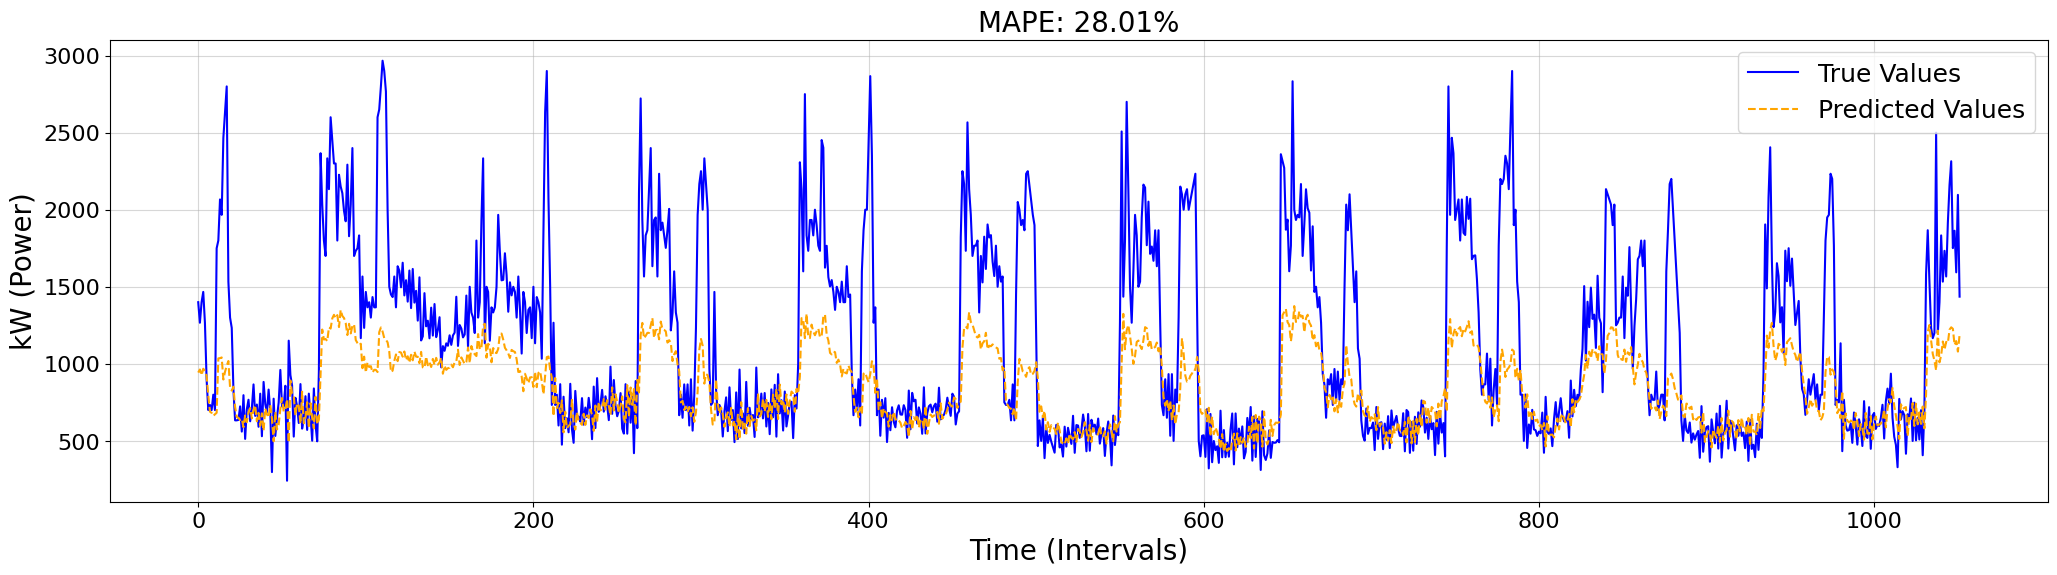

In [46]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ==============================================================
# 1. Định nghĩa PositionalEncoding
# ==============================================================
class PositionalEncoding(nn.Module):
    """
    Thêm encoding sin/cos cho chuỗi thời gian
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

        self.pe = pe.unsqueeze(1)  # shape: (max_len, 1, d_model)

    def forward(self, x):
        """
        x: [seq_len, batch_size, d_model]
        """
        seq_len = x.size(0)
        # Cộng thêm positional encoding
        x = x + self.pe[:seq_len, :]
        return x

# ==============================================================
# 2. Định nghĩa Encoder, Decoder, MultiDeT (có PE & nhiều layers)
# ==============================================================
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead=4, dropout=0.1):
        super(Encoder, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=False  # PyTorch mặc định Seq x Batch x Feature
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x: [seq_len, batch_size, d_model]
        x = self.pos_encoder(x)
        x = self.encoder(x)  # [seq_len, batch_size, d_model]
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead=4, dropout=0.2):
        super(Decoder, self).__init__()
        self.pos_decoder = PositionalEncoding(d_model)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=False
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, memory, x):
        # memory: [seq_len_enc, batch_size, d_model]
        # x: [seq_len_dec, batch_size, d_model]
        x = self.pos_decoder(x)
        x = self.decoder(x, memory)  # [seq_len_dec, batch_size, d_model]
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, 
                 encoder_layers=2, 
                 decoder_layers=2, 
                 d_model=32, 
                 nhead=4,
                 dropout=0.2,
                 encoder_input_dim=10, 
                 decoder_input_dim=10):
        """
        encoder_input_dim, decoder_input_dim là số chiều đầu vào tương ứng cho Encoder và Decoder
        """
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(encoder_input_dim, d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoderLinear = nn.Sequential(
            nn.Linear(decoder_input_dim, d_model),
            nn.BatchNorm1d(d_model)
        )

    def forward(self, src, src_dec):
        """
        src:    [batch_size, seq_len_enc, encoder_input_dim]
        src_dec:[batch_size, seq_len_dec, decoder_input_dim]
        """
        # Permute to [seq_len, batch_size, input_dim]
        src = src.permute(1, 0, 2)      # => [seq_len_enc, batch_size, encoder_input_dim]
        src_dec = src_dec.permute(1, 0, 2)  # => [seq_len_dec, batch_size, decoder_input_dim]

        seq_len_enc, batch_size, enc_input_dim = src.shape
        seq_len_dec, _, dec_input_dim = src_dec.shape

        # Encoder path
        enc = src.reshape(-1, enc_input_dim)
        enc = self.encoderLinear(enc)  # => (seq_len_enc*batch_size, d_model)
        enc = enc.reshape(seq_len_enc, batch_size, -1)  
        memory = self.encoder(enc)     # => (seq_len_enc, batch_size, d_model)

        # Decoder path
        dec = src_dec.reshape(-1, dec_input_dim)
        dec = self.decoderLinear(dec)  # => (seq_len_dec*batch_size, d_model)
        dec = dec.reshape(seq_len_dec, batch_size, -1)
        out = self.decoder(memory, dec)  # => (seq_len_dec, batch_size, 1)

        # Lấy phần tử cuối cùng của seq_len_dec
        return out[-1]  # [batch_size, 1]

# ==============================================================
# 3. Xây dựng Dataset trả về (X_enc, X_dec, y)
# ==============================================================
class CustomDataset(Dataset):
    """
    Dataset này sẽ tạo sliding windows cho Encoder (quá khứ) và Decoder (có thể là 1 bước trước)
    để phù hợp với kiến trúc của MultiDeT.
    """
    def __init__(self, data, features_to_keep, window_size=4, target_step=0):
        super(CustomDataset, self).__init__()
        self.data = data[features_to_keep].copy().reset_index(drop=True)
        self.window_size = window_size
        self.target_step = target_step

        # Ở đây mặc định cột 'Load' là nhãn (y).
        self.idx_load = self.data.columns.get_loc('Load')

    def __len__(self):
        return len(self.data) - self.window_size - self.target_step

    def __getitem__(self, idx):
        # Encoder input
        X_enc = self.data.iloc[idx : idx + self.window_size, :].values
        # Decoder input: ví dụ lấy 1 bước
        X_dec = self.data.iloc[idx + self.window_size - 1 : idx + self.window_size, :].values

        # y tại thời điểm idx + window_size + target_step
        y = self.data.iloc[idx + self.window_size + self.target_step, self.idx_load]

        return (
            torch.tensor(X_enc, dtype=torch.float32),
            torch.tensor(X_dec, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32)
        )

# ==============================================================
# 4. Xây dựng ModelManager để tiện tiền xử lý dữ liệu
# ==============================================================
class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep,
                 window_size=4, target_step=0):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step

        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

    def preprocess_data(self):
        """
        Tiền xử lý dữ liệu, scale X và y độc lập.
        """
        train_X = self.train_data[self.features_to_keep].copy()
        test_X = self.test_data[self.features_to_keep].copy()

        # Tách cột Load
        train_load = train_X.pop('Load').values.reshape(-1, 1)
        test_load = test_X.pop('Load').values.reshape(-1, 1)

        # Scale Load (y) riêng
        self.scaler_y.fit(train_load)
        train_load_scaled = self.scaler_y.transform(train_load)
        test_load_scaled = self.scaler_y.transform(test_load)

        # Scale các feature X còn lại
        self.scaler_X.fit(train_X)
        train_X_scaled = self.scaler_X.transform(train_X)
        test_X_scaled = self.scaler_X.transform(test_X)

        # Ghép Load vào lại đầu dataframe
        train_scaled = np.concatenate([train_load_scaled, train_X_scaled], axis=1)
        test_scaled = np.concatenate([test_load_scaled, test_X_scaled], axis=1)

        # Tạo dataframe sau khi scale
        self.train_data_scaled = pd.DataFrame(train_scaled, 
                                             columns=['Load'] + list(train_X.columns))
        self.test_data_scaled = pd.DataFrame(test_scaled, 
                                            columns=['Load'] + list(test_X.columns))

    def get_dataloaders(self, batch_size=32):
        dataset_train = CustomDataset(self.train_data_scaled, self.features_to_keep,
                                      window_size=self.window_size, 
                                      target_step=self.target_step)
        dataset_test = CustomDataset(self.test_data_scaled, self.features_to_keep,
                                     window_size=self.window_size, 
                                     target_step=self.target_step)

        # Tách 10% train làm val
        val_size = int(0.1 * len(dataset_train))
        train_size = len(dataset_train) - val_size

        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset_train, [train_size, val_size]
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# ==============================================================
# 5. Định nghĩa hàm evaluate_model (giữ nguyên)
# ==============================================================
def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values = []
    predicted_values = []

    with torch.no_grad():
        for X_enc, X_dec, y in test_loader:
            output = model(X_enc, X_dec)
            output = output.view(-1)

            loss = criterion(output, y.view(-1))
            test_loss += loss.item() * X_enc.size(0)

            true_values.extend(y.cpu().numpy())
            predicted_values.extend(output.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)

    # inverse_transform
    true_values = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predicted_values = scaler_y.inverse_transform(predicted_values.reshape(-1, 1)).flatten()

    # Tính MAPE
    mape = np.mean(np.abs((true_values - predicted_values) / (true_values + 1e-9))) * 100
    print(f'MAPE: {mape:.2f}%')

    return true_values, predicted_values, mape

# ==============================================================
# 6. Định nghĩa hàm huấn luyện (có Early Stopping & scheduler)
# ==============================================================
def train_model_until_mape_threshold(model, 
                                     train_loader, 
                                     val_loader, 
                                     criterion, 
                                     optimizer,
                                     num_epochs=2000, 
                                     test_loader=None, 
                                     scaler_y=None,
                                     mape_threshold=8, 
                                     model_save_path="best_model.pth",
                                     patience=20):
    """
    - mape_threshold: dừng khi MAPE trên test < mape_threshold (%).
    - patience: số epoch chờ đợi nếu val_loss không cải thiện.
    """
    # Scheduler để giảm lr khi val_loss không giảm
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # === Training ===
        model.train()
        running_loss = 0.0
        for X_enc, X_dec, y in train_loader:
            optimizer.zero_grad()
            output = model(X_enc, X_dec)  # [batch_size, 1]
            output = output.view(-1)
            
            loss = criterion(output, y.view(-1))
            # Nếu muốn train bằng MAPE, ta có thể dùng custom MAPE loss:
            # mape_loss = torch.mean(torch.abs((y - output)/(y+1e-9))) * 100
            # mape_loss.backward()
            # hoặc giữ MSE loss:
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # === Validation ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_dec, y in val_loader:
                output = model(X_enc, X_dec)
                output = output.view(-1)
                loss = criterion(output, y.view(-1))
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Bước scheduler
        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, LR={optimizer.param_groups[0]["lr"]}')

        # Check Early Stopping dựa trên val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("[Early Stopping] No improvement in Val Loss.")
            break

        # Đánh giá MAPE trên test set (nếu có)
        if test_loader is not None and scaler_y is not None:
            _, _, mape = evaluate_model(model, test_loader, criterion, scaler_y)
            # Dừng nếu MAPE < ngưỡng
            if mape < mape_threshold:
                print(f"MAPE threshold reached: {mape:.2f}%. Stopping training and saving model.")
                torch.save(model.state_dict(), model_save_path)
                print(f"Model saved to {model_save_path}")
                break

    return train_losses, val_losses

# ==============================================================
# 7. Chạy thử toàn bộ quy trình
# ==============================================================
if __name__ == "__main__":
    # Ví dụ minh hoạ
    train_data = pd.read_csv("train_delta_c.csv")
    test_data = pd.read_csv("test_delta_o.csv")

    features_to_keep = [
        'Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
        'relative_humidity','clearsky_dni','zenith','Day','Month','D_1_h','D_2_h','D_3_h',
        'uv_index','dewpoint_temp','Hour','Minute'
    ]

    # Khởi tạo ModelManager
    manager = ModelManager(
        train_data=train_data,
        test_data=test_data,
        features_to_keep=features_to_keep,
        window_size=4,
        target_step=0
    )
    manager.preprocess_data()

    # Lấy DataLoader
    train_loader, val_loader, test_loader = manager.get_dataloaders(batch_size=32)

    # Chiều đầu vào cho encoder/decoder = len(features_to_keep)
    encoder_input_dim = len(features_to_keep)
    decoder_input_dim = len(features_to_keep)

    # Khởi tạo mô hình MultiDeT (Transformer)
    model = MultiDeT(
        encoder_layers=3,      # tăng số layer
        decoder_layers=2,
        d_model=32,            # tăng d_model
        nhead=4,               # nhead <= d_model
        dropout=0.2,
        encoder_input_dim=encoder_input_dim,
        decoder_input_dim=decoder_input_dim
    )

    # Khởi tạo criterion, optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

    # Huấn luyện mô hình
    train_losses, val_losses = train_model_until_mape_threshold(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=1000,
        test_loader=test_loader,
        scaler_y=manager.scaler_y,
        mape_threshold=8.0,    # dừng nếu MAPE < 8%
        model_save_path="best_model.pth",
        patience=1000            # early stopping nếu 15 epoch không cải thiện val_loss
    )

    # Đánh giá mô hình trên test set
    true_values, predicted_values, mape = evaluate_model(
        model, test_loader, criterion, manager.scaler_y
    )

    # Vẽ kết quả
    plt.figure(figsize=(25, 6))
    plt.plot(true_values, label='True Values', color='blue')
    plt.plot(predicted_values, label='Predicted Values', color='orange', linestyle='--')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.xlabel('Time (Intervals)', fontsize=20)
    plt.ylabel('kW (Power)', fontsize=20)
    plt.legend(fontsize=18)
    plt.title(f'MAPE: {mape:.2f}%', fontsize=20)
    plt.grid(alpha=0.5)
    plt.show()


## SSA

In [53]:
import numpy as np
from sklearn.preprocessing import StandardScaler

total_samples = len(X_test)
train_percentage = 0.8
train_size = int(total_samples * train_percentage)
train_size = train_size - (train_size % 96)
# Sử dụng slicing cho numpy.ndarray
X_train_ssa = X_test[:train_size]  # Chọn các hàng đầu tiên
y_train_ssa = y_test[:train_size]
X_test_ssa = X_test[train_size:]  # Chọn các hàng còn lại
y_test_ssa = y_test[train_size:]

scaler = StandardScaler()
X_train_scaled_ssa = scaler.fit_transform(X_train_ssa)
X_test_scaled_ssa = scaler.transform(X_test_ssa)


y_pred_1 = manager.predict("Decision Tree Regressor", X_test_ssa, y_test_ssa)["y_pred"]
y_pred_2 = manager.predict("Random Forest Regressor", X_test_ssa, y_test_ssa)["y_pred"]
y_pred_3 = manager.predict("XGBoost Regressor", X_test_ssa, y_test_ssa)["y_pred"]
y_pred_4 = manager.predict("CatBoost Regressor", X_test_ssa, y_test_ssa)["y_pred"]

predictions_matrix_test_ssa = np.column_stack([y_pred_1, y_pred_2, y_pred_3, y_pred_4])
X_input = predictions_matrix_test_ssa
y_output = y_test_ssa

X_train_scaled_ssa.shape, X_test_scaled_ssa.shape
X_test_ssa.shape, X_train_ssa.shape


((284, 112), (768, 112))

In [61]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Normalize weights so their sum equals 1
def normalize_weights(weights):
    return weights / np.sum(weights)

# Objective function to evaluate fitness
def objective_function(weights, y_preds, y_test_ssa):
    weights = normalize_weights(weights)
    ensemble_prediction = np.dot(y_preds, weights)
    
    # Check for NaN in predictions or test labels
    if np.isnan(ensemble_prediction).any() or np.isnan(y_test_ssa).any():
        return np.inf  # Return a large value for fitness if NaN is encountered
    
    mse = mean_squared_error(y_test_ssa, ensemble_prediction)
    return mse

# SSA optimization algorithm
def ssa(objective_function, y_preds, y_test_ssa, n_particles, n_iterations, weight_bounds, verbose=False):
    S = n_particles
    A = n_iterations
    num_models = y_preds.shape[1]
    salps = np.random.uniform(weight_bounds[0], weight_bounds[1], (S, num_models))
    salps = np.array([normalize_weights(salp) for salp in salps])  # Normalize initial salps
    fitness = np.array([objective_function(salp, y_preds, y_test_ssa) for salp in salps])
    best_idx = np.argmin(fitness)  # Index of the best particle
    best_weights = salps[best_idx]
    best_fitness = fitness[best_idx]
    r1 = np.linspace(1, 0, A)  # Exploration to exploitation parameter

    # Track fitness over time
    fitness_over_time = [best_fitness]

    for a in range(A):
        for i in range(S):
            if i == 0:
                # Update leader salp
                salps[i] = best_weights + r1[a] * np.random.uniform(-1, 1, num_models) * (weight_bounds[1] - weight_bounds[0])
            else:
                # Update follower salps
                salps[i] = salps[i] + r1[a] * (salps[np.random.randint(S)] - salps[i])
            
            # Ensure weights are clipped within bounds and normalized
            salps[i] = np.clip(salps[i], weight_bounds[0], weight_bounds[1])
            salps[i] = normalize_weights(salps[i])

            # Update fitness if improved
            current_fitness = objective_function(salps[i], y_preds, y_test_ssa)
            if current_fitness < fitness[i]:
                fitness[i] = current_fitness
                if current_fitness < best_fitness:
                    best_weights = salps[i]
                    best_fitness = current_fitness
        
        # Append the best fitness for the current iteration
        fitness_over_time.append(best_fitness)
        
        if verbose:
            print(f"Iteration {a + 1}/{A}, Best Fitness: {best_fitness:.6f}")
            print(f"Best Weights: {best_weights}")
    
    return best_weights, best_fitness, fitness_over_time

# Validate predictions matrix and test labels
if np.isnan(predictions_matrix_test_ssa).any():
    raise ValueError("Predictions matrix contains NaN values. Please check your models.")
if np.isnan(y_test_ssa).any():
    raise ValueError("Test labels contain NaN values. Please ensure the data is clean.")

# SSA optimization loop
n_particles = 100
n_iterations = 30
weight_bounds = (0, 1)

optimized_weights = []
combined_predictions = []
all_fitness_over_time = []  # To store fitness evolution for all instances

for t in range(len(y_test_ssa)):
    y_actual_t = np.array([y_test_ssa[t]])  # Single test label
    y_preds_t = predictions_matrix_test_ssa[t, :].reshape(1, -1)  # Predictions for a single test instance
    
    # Check for NaN in instance-level predictions
    if np.isnan(y_preds_t).any() or np.isnan(y_actual_t).any():
        continue  # Skip iteration if NaN found
    
    best_weights_t, best_fitness_t, fitness_over_time = ssa(
        objective_function, 
        y_preds_t, 
        y_actual_t, 
        n_particles, 
        n_iterations, 
        weight_bounds, 
        verbose=True  # Enable verbose for debugging
    )
    optimized_weights.append(best_weights_t)
    combined_predictions.append(np.dot(y_preds_t, best_weights_t)[0])  # Weighted ensemble prediction
    all_fitness_over_time.append(fitness_over_time)  # Save fitness evolution for this instance

optimized_weights = np.array(optimized_weights)
combined_predictions = np.array(combined_predictions)

# # Visualize fitness evolution over time
# import matplotlib.pyplot as plt

# for i, fitness_over_time in enumerate(all_fitness_over_time):
#     plt.plot(fitness_over_time, label=f'Instance {i + 1}')
# plt.xlabel('Iteration')
# plt.ylabel('Best Fitness')
# plt.title('Fitness Evolution Over Time (SSA)')
# plt.legend()
# plt.show()


Iteration 1/30, Best Fitness: 1.283487
Best Weights: [0.29550091 0.02962031 0.27578658 0.3990922 ]
Iteration 2/30, Best Fitness: 1.283487
Best Weights: [0.29550091 0.02962031 0.27578658 0.3990922 ]
Iteration 3/30, Best Fitness: 0.001897
Best Weights: [0.15592457 0.11223772 0.16407176 0.56776596]
Iteration 4/30, Best Fitness: 0.001897
Best Weights: [0.33989248 0.14538493 0.1780701  0.33665249]
Iteration 5/30, Best Fitness: 0.001897
Best Weights: [0.34612199 0.14925732 0.18169334 0.32292734]
Iteration 6/30, Best Fitness: 0.001897
Best Weights: [0.32948907 0.19163484 0.17739496 0.30148113]
Iteration 7/30, Best Fitness: 0.001897
Best Weights: [0.32148234 0.27565064 0.13741177 0.26545525]
Iteration 8/30, Best Fitness: 0.001897
Best Weights: [0.47047905 0.19667364 0.101993   0.2308543 ]
Iteration 9/30, Best Fitness: 0.001897
Best Weights: [0.39881141 0.17328351 0.13190963 0.29599545]
Iteration 10/30, Best Fitness: 0.001897
Best Weights: [0.37162835 0.19163587 0.13878163 0.29795415]
Iteration

In [ ]:
def sigmoid(x, L=1, x0=0, k=0.01):
    return L / (1 + np.exp(-k * (x - x0)))
def normalize_weights(weights):
    return weights / np.sum(weights)

def objective_function(weights, y_preds, y_test_ssa):
    weights = normalize_weights(weights)
    ensemble_prediction = np.dot(y_preds, weights)
    
    if np.isnan(ensemble_prediction).any() or np.isnan(y_test_ssa).any():
        return np.inf  
    
    mse = mean_squared_error(y_test_ssa, ensemble_prediction)
    return mse


def ssa(objective_function, y_preds, y_test_ssa, n_particles, n_iterations, weight_bounds, verbose=False):
    S = n_particles
    A = n_iterations
    num_models = y_preds.shape[1]
    salps = np.random.uniform(weight_bounds[0], weight_bounds[1], (S, num_models))
    salps = np.array([normalize_weights(salp) for salp in salps])  # Normalize initial salps
    fitness = np.array([objective_function(salp, y_preds, y_test_ssa) for salp in salps])
    best_idx = np.argmin(fitness) 
    best_weights = salps[best_idx]
    best_fitness = fitness[best_idx]
    # r1 = np.linspace(1, 0, A)  
    r1 = sigmoid(np.linspace(-A/2, A/2, A), L=1, x0=0, k=0.01)

    fitness_over_time = [best_fitness]
    for a in range(A):
        for i in range(S):
            if i == 0:
                salps[i] = best_weights + r1[a] * np.random.uniform(-1, 1, num_models) * (weight_bounds[1] - weight_bounds[0])
            else:
                salps[i] = salps[i] + r1[a] * (salps[np.random.randint(S)] - salps[i])
            
            salps[i] = np.clip(salps[i], weight_bounds[0], weight_bounds[1])
            salps[i] = normalize_weights(salps[i])

            current_fitness = objective_function(salps[i], y_preds, y_test_ssa)
            if current_fitness < fitness[i]:
                fitness[i] = current_fitness
                if current_fitness < best_fitness:
                    best_weights = salps[i]
                    best_fitness = current_fitness
        
        fitness_over_time.append(best_fitness)
        if verbose:
            print(f"Iteration {a + 1}/{A}, Best Fitness: {best_fitness:.6f}")
    return best_weights, best_fitness, fitness_over_time

n_particles = 200
n_iterations = 50
weight_bounds = (0, 1)

all_fitness_over_time = [] 

for t in range(len(y_test_ssa)):
    y_actual_t = np.array([y_test_ssa[t]]) 
    y_preds_t = predictions_matrix_test_ssa[t, :].reshape(1, -1)  # Predictions for a single test instance
    
    if np.isnan(y_preds_t).any() or np.isnan(y_actual_t).any():
        continue  
    print(f"Instance {t + 1}:")
    _, _, fitness_over_time = ssa(
        objective_function, 
        y_preds_t, 
        y_actual_t, 
        n_particles, 
        n_iterations, 
        weight_bounds, 
        verbose=False  
    )
    all_fitness_over_time.append(fitness_over_time)
    
    for iteration, fitness in enumerate(fitness_over_time, start=1):
        print(f"Iteration {iteration}/{n_iterations}, Fitness: {fitness:.6f}")

Instance 1:
Iteration 1/50, Fitness: 0.007923
Iteration 2/50, Fitness: 0.007923
Iteration 3/50, Fitness: 0.007923
Iteration 4/50, Fitness: 0.007923
Iteration 5/50, Fitness: 0.007923
Iteration 6/50, Fitness: 0.007923
Iteration 7/50, Fitness: 0.007923
Iteration 8/50, Fitness: 0.007923
Iteration 9/50, Fitness: 0.007923
Iteration 10/50, Fitness: 0.007923
Iteration 11/50, Fitness: 0.007923
Iteration 12/50, Fitness: 0.007923
Iteration 13/50, Fitness: 0.007923
Iteration 14/50, Fitness: 0.007923
Iteration 15/50, Fitness: 0.007923
Iteration 16/50, Fitness: 0.007923
Iteration 17/50, Fitness: 0.007923
Iteration 18/50, Fitness: 0.007923
Iteration 19/50, Fitness: 0.007923
Iteration 20/50, Fitness: 0.007923
Iteration 21/50, Fitness: 0.007923
Iteration 22/50, Fitness: 0.007923
Iteration 23/50, Fitness: 0.007923
Iteration 24/50, Fitness: 0.007923
Iteration 25/50, Fitness: 0.007923
Iteration 26/50, Fitness: 0.007923
Iteration 27/50, Fitness: 0.007923
Iteration 28/50, Fitness: 0.007923
Iteration 29/50, 

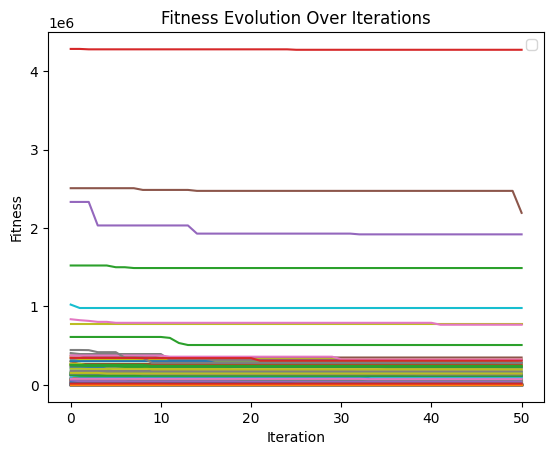

In [84]:
import matplotlib.pyplot as plt

for i, fitness_over_time in enumerate(all_fitness_over_time):
    plt.plot(fitness_over_time)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Fitness Evolution Over Iterations')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

best_weights_all = []  # List to store best weights for each time instance
best_mse_all = []      # List to store the smallest MSE for each time instance

for t in range(len(y_test_ssa)):
    y_actual_t = np.array([y_test_ssa[t]]) 
    y_preds_t = predictions_matrix_test_ssa[t, :].reshape(1, -1)  # Predictions for a single test instance

    if np.isnan(y_preds_t).any() or np.isnan(y_actual_t).any():
        continue  

    print(f"Processing Instance {t + 1}...")
    best_weights, best_fitness, _ = ssa(
        objective_function, 
        y_preds_t, 
        y_actual_t, 
        n_particles, 
        n_iterations, 
        weight_bounds, 
        verbose=False
    )

    best_weights_all.append(best_weights)
    best_mse_all.append(best_fitness)

    print(f"Best Weights for Instance {t + 1}: {best_weights}")
    print(f"Best MSE for Instance {t + 1}: {best_fitness:.6f}")

# Convert best weights to a DataFrame
weights_df = pd.DataFrame(best_weights_all, columns=[f'w{i+1}' for i in range(len(best_weights_all[0]))])
weights_df.insert(0, 'Index', range(1, len(best_weights_all) + 1))  # Add index column

# Print the DataFrame
print("\nWeights for each index:")
print(weights_df)

# Save the DataFrame to a CSV file (optional)
weights_df.to_csv('weights_results.csv', index=False)


Processing Instance 1...
Best Weights for Instance 1: [0.23771011 0.25433794 0.26411988 0.24383207]
Best MSE for Instance 1: 0.098534
Processing Instance 2...
Best Weights for Instance 2: [0.         0.         0.54024357 0.45975643]
Best MSE for Instance 2: 6.656110
Processing Instance 3...
Best Weights for Instance 3: [0.16099531 0.83900469 0.         0.        ]
Best MSE for Instance 3: 31535.613843
Processing Instance 4...
Best Weights for Instance 4: [nan nan nan nan]
Best MSE for Instance 4: 40.829730
Processing Instance 5...
Best Weights for Instance 5: [0.19975861 0.3969796  0.         0.40326178]
Best MSE for Instance 5: 114077.371350
Processing Instance 6...
Best Weights for Instance 6: [0.         0.21059631 0.49607679 0.2933269 ]
Best MSE for Instance 6: 14449.676469
Processing Instance 7...
Best Weights for Instance 7: [0.24341279 0.24552812 0.25567695 0.25538214]
Best MSE for Instance 7: 0.000553
Processing Instance 8...
Best Weights for Instance 8: [0.60303301 0.33218942

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

time_index = np.arange(len(y_test_ssa))

results_df = pd.DataFrame({
    "time_index": time_index,
    "y_actual": y_test_ssa,
    "y_pred_cb": predictions_matrix_test_ssa[:, 0],
    "y_pred_rf": predictions_matrix_test_ssa[:, 1],
    "y_pred_xgb": predictions_matrix_test_ssa[:, 2],
    "y_combine": combined_predictions
})

for i in range(predictions_matrix_test_ssa.shape[1]):
    results_df[f"weight_model_{i+1}"] = optimized_weights[:, i]

print("\nKết quả tối ưu hóa với trọng số thay đổi theo thời gian (10 dòng đầu):")
print(results_df.head(10))

results_df.to_csv(rf"c:\Users\USER\Downloads\weight_per_time.csv", index=False)

plt.figure(figsize=(12, 6))
for i in range(optimized_weights.shape[1]):
    plt.plot(results_df["time_index"], optimized_weights[:, i], label=f"Weight Model {i+1}")
plt.title("Optimized Weights Over Time")
plt.xlabel("Time Index")
plt.ylabel("Weight Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('c:/Users/USER/OneDrive - TNDigi Digital Marketing/Attachments/Uyen/Project/Ellie/PROJECT/Kaogang/1. Data/w15.csv')

data['Time'] = pd.to_datetime(data['Time'])
data['hour'] = data['Time'].dt.hour + data['Time'].dt.minute / 60  

features_to_cluster = ['hour','clearsky_dni']  
data_cluster = data[features_to_cluster]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)  
data['cluster'] = kmeans.fit_predict(scaled_data) + 1  

plt.figure(figsize=(10, 6))
plt.scatter(data['hour'], data['kW'], c=data['cluster'], cmap='viridis', s=100)
plt.title('K-Means Clustering ')
plt.xlabel('Time (15-min interval)')
plt.ylabel('Load (kW)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

for cluster in sorted(data['cluster'].unique()):
    hours_in_cluster = data[data['cluster'] == cluster]['hour'].unique()
    print(f"Cluster {cluster}: Hours -> {sorted(hours_in_cluster)}")



data.to_csv('c:/Users/USER/OneDrive - TNDigi Digital Marketing/Attachments/Uyen/Project/Ellie/PROJECT/Kaogang/1. Data/w15_cluster.csv', index=False)


In [ ]:
import csv
import numpy as np

# Initialize arrays for optimized weights and combined predictions
optimized_weights = []  
combined_predictions = [] 

# Loop through each time step and calculate optimal weights and combined predictions
for t in range(len(y_test_ssa)):
    y_actual_t = np.array([y_test_ssa[t]])  
    y_preds_t = predictions_matrix_test_ssa[t, :].reshape(1, -1)  
    
    # Run the SSA optimization
    best_weights_t, best_fitness_t = ssa(
        objective_function, 
        y_preds_t, 
        y_actual_t, 
        n_particles, 
        n_iterations, 
        weight_bounds, 
        verbose=False
    )

    # Append results
    optimized_weights.append(best_weights_t)
    combined_predictions.append(np.dot(y_preds_t, best_weights_t)[0])
    
    # Calculate and print MSE and optimal weights for the current time step
    mse_t = np.mean((y_actual_t - np.dot(y_preds_t, best_weights_t))**2)
    print(f"Thời điểm {t + 1}: Trọng số tối ưu = {best_weights_t}, MSE = {mse_t}")

# Convert results to numpy arrays
optimized_weights = np.array(optimized_weights)
combined_predictions = np.array(combined_predictions)

# Save optimized weights to a CSV file
output_file = rf"c:\\Users\\USER\\Downloads\\optimal_weight.csv"
header = ["time_index"] + [f"weight {i+1}" for i in range(optimized_weights.shape[1])]

with open(output_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for t, weights in enumerate(optimized_weights):
        row = [t + 1] + weights.tolist()
        writer.writerow(row)

print(f"Optimized weights have been saved to {output_file}.")


In [ ]:
import csv
import numpy as np
import pandas as pd

time_index = np.arange(1, len(y_test_ssa) + 1)

results_df = pd.DataFrame({
    "time_index": time_index,
    "y_actual": y_test_ssa,
    "y_pred_cb": predictions_matrix_test_ssa[:, 0],
    "y_pred_rf": predictions_matrix_test_ssa[:, 1],
    "y_pred_xgb": predictions_matrix_test_ssa[:, 2]
})

for i in range(optimized_weights.shape[1]):
    results_df[f"weight_{i+1}"] = optimized_weights[:, i]

# Calculate yssa
results_df["yssa"] = (
    results_df["weight_1"] * results_df["y_pred_cb"] +
    results_df["weight_2"] * results_df["y_pred_rf"] +
    results_df["weight_3"] * results_df["y_pred_xgb"]
)

# Calculate MAPE (Mean Absolute Percentage Error)
results_df["mape"] = (np.abs((results_df["y_actual"] - results_df["yssa"]) / results_df["y_actual"])) * 100

# Calculate average MAPE
average_mape = results_df["mape"].mean()
print(f"Average MAPE: {average_mape:.2f}%")

output_file = r"c:\Users\USER\Downloads\optimal_weights_full.csv"
# results_df.to_csv(output_file, index=False, encoding="utf-8")

print(f"Results have been saved to {output_file}.")
results_df
